In [57]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import math
from sklearn.kernel_ridge import KernelRidge

plt.rcParams["figure.figsize"] = (20,6)

### Criando funções

In [58]:
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [59]:
def apl_model (df_st,n_lags):

    print('Janela Analisada: ', n_lags,'dias\n')

    X = get_lags(df_st, n_lags)
    y = df_st.reindex(X.index)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.3)

    parameters = {'kernel':['linear', 'rbf', 'sigmoid', 'polynomial', 'laplacian', 'chi2'],
             'gamma': ['scale', 'auto'],
             'alpha': [1, 0.1, 0.01, 0.001]
             }

    kr = KernelRidge()
    kr_GS = GridSearchCV (kr, parameters, cv = TimeSeriesSplit())
    res = kr_GS.fit(X_train,y_train)

    print('#'*40)
    print('Melhor Score: ', res.best_score_)
    print('Melhores Parametros: ', res.best_params_)
    print('#'*40)

    print('Aplicando o Medelo Para os Melhores Parametros: \n\n\n')

    parameters = {'kernel': [res.best_params_['kernel']],
             'gamma': [res.best_params_['gamma']],
             'alpha': [res.best_params_['alpha']]}
    
    kr = KernelRidge()
    kr_GS = GridSearchCV (kr, parameters, cv = TimeSeriesSplit())
    res = kr_GS.fit(X_train,y_train)
    print( res.best_score_, res.best_params_)

    r2 = r2_score(kr_GS.predict(X_test),y_test)
    mse = mean_squared_error(kr_GS.predict(X_test),y_test)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(kr_GS.predict(X_test),y_test)
    mape = mean_absolute_percentage_error(kr_GS.predict(X_test),y_test)

    print('KRR model Results')
    print('r2' ,r2)
    print('mse' , mse)
    print('rmse', rmse)
    print('mae', mae)
    print('mape',  mape)

    #plot previsão com teste
    fig, ax = plt.subplots()
    ax.plot(kr_GS.predict(X_test).flatten(), label='Previsões', color = 'b')
    ax.plot(y_test.reset_index(drop=True), label='Real', color= 'y')
    plt.title('Real x Previsto')
    plt.legend()
    plt.show();


    #plot de total com previsão
    previsao = pd.DataFrame(kr_GS.predict(X_test).flatten(), index = X_test.index)
    concat = pd.concat([y_train, previsao],axis=1)

    concat.plot(linewidth=2,figsize=(20,7), color=['y','b'])
    plt.legend(['Real','Previsões'], fontsize=15)
    plt.xlabel('Período', size=15)
    plt.title('Real x Previsto',size=15)
    plt.show();

    fig, ax = plt.subplots()
    ax.plot(df_st, label='Real', color = 'y')
    ax.plot(previsao, label='Previsões', linewidth=2, color='b')
    plt.title('Real x Previsto')
    plt.legend()
    plt.show();


    
    return r2, mse, rmse, mae, mape
    

In [60]:
def apl_for_lags (df_st):
    janelas = [ 7, 15, 30, 45, 60]
    results = []

    for janela in janelas:
        r2, mse, rmse, mae, mape = apl_model (df_st, janela)
        result = [r2, mse, rmse, mae, mape]
        results.append(result)

    return results

### Lendo o dataset

In [61]:
df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')

df_st = df['data_notificacao'].value_counts().rename_axis('Data_notificacao').to_frame('N_casos')
df_st.sort_index(inplace = True)
df_st

C:\Users\gabri\AppData\Local\Temp\ipykernel_9064\2810962173.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\df_casos_leves')


,N_casos
Data_notificacao,
2020-01-12,1
2020-01-20,3
2020-01-22,1
2020-01-24,1
2020-01-25,1
...,...
2022-06-17,1327
2022-06-18,550
2022-06-19,552


### Aplicando Modelo

Janela Analisada:  7 dias

########################################
Melhor Score:  0.6532410520098045
Melhores Parametros:  {'alpha': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.6532410520098045 {'alpha': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
KRR model Results
r2 0.6748525022682883
mse 780233.337257101
rmse 883.308177963445
mae 465.53977897799746
mape 0.39214161722539337


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-package

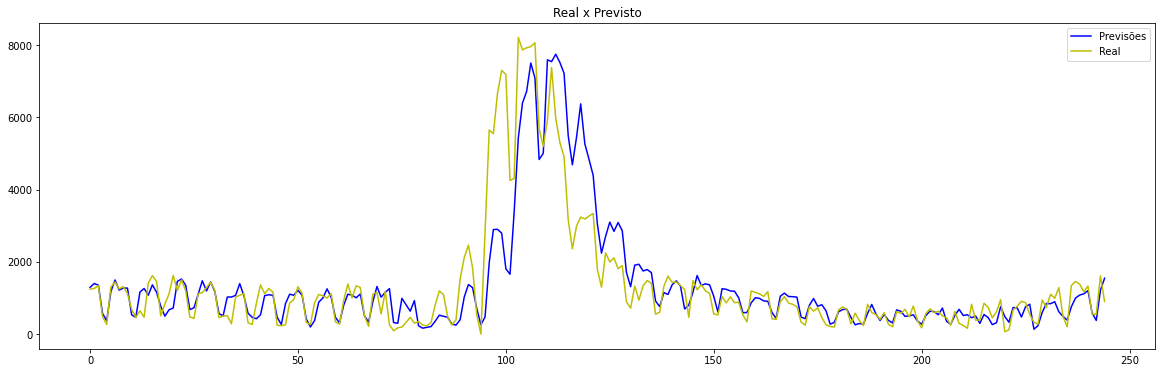

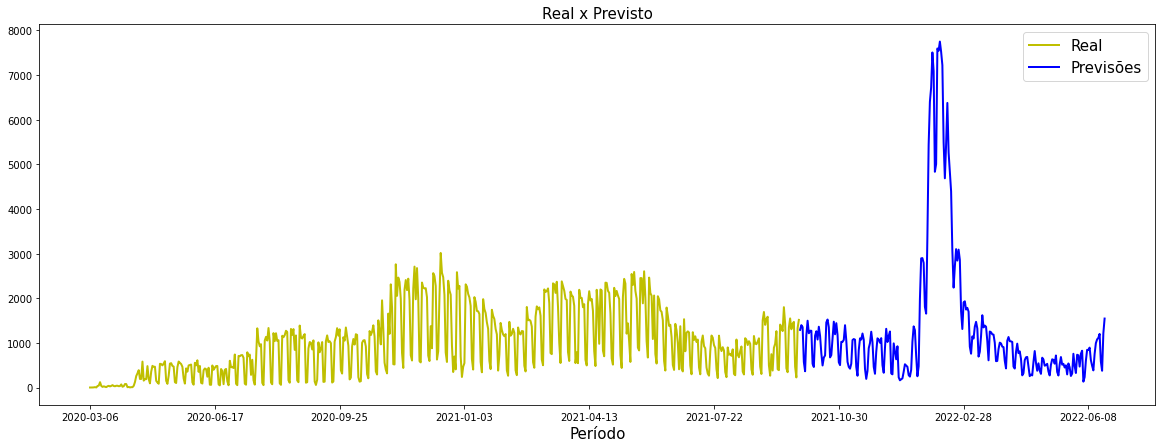

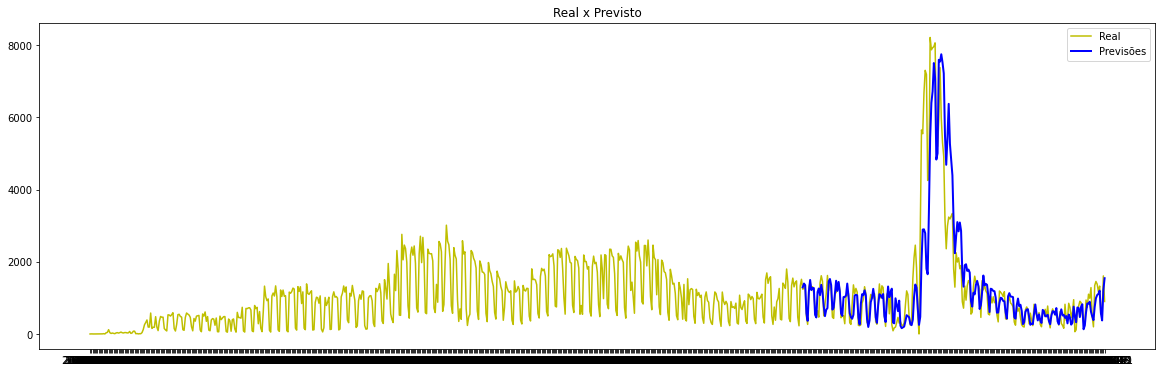

Janela Analisada:  15 dias

########################################
Melhor Score:  0.6831891318441882
Melhores Parametros:  {'alpha': 1, 'gamma': 'scale', 'kernel': 'linear'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.6831891318441882 {'alpha': 1, 'gamma': 'scale', 'kernel': 'linear'}
KRR model Results
r2 0.759946387042844
mse 551420.8870023579
rmse 742.5771926219912
mae 403.9143796873487
mape 0.3598412527246634


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-package

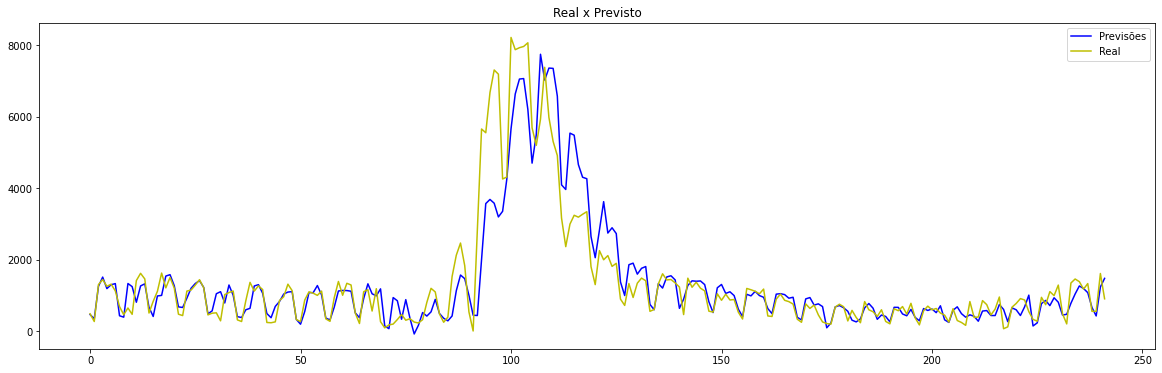

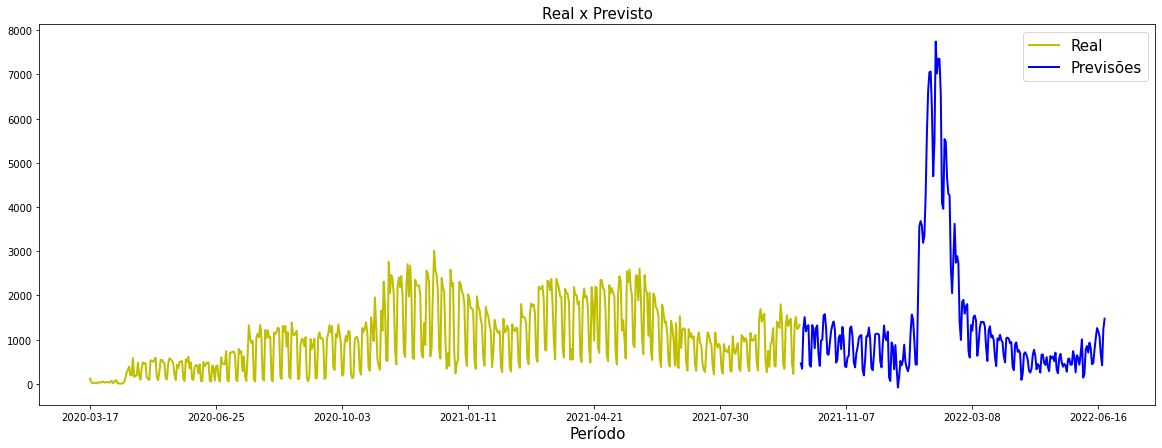

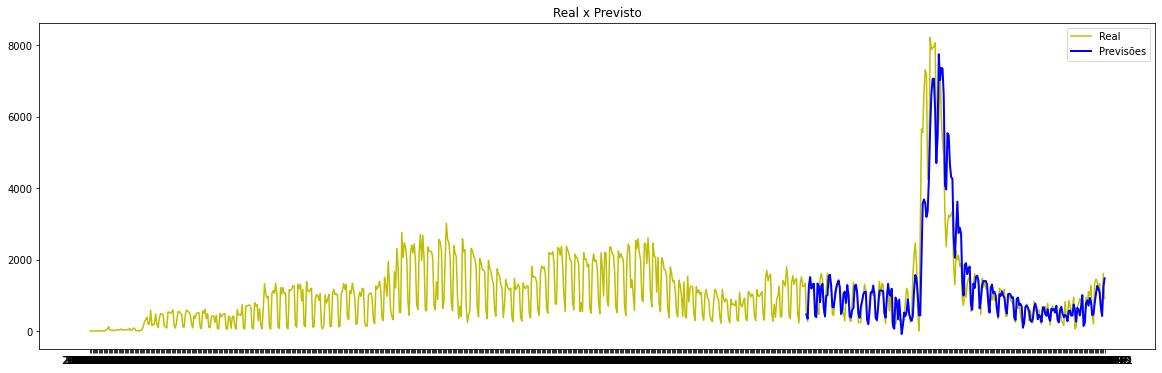

Janela Analisada:  30 dias

########################################
Melhor Score:  0.6973123181707714
Melhores Parametros:  {'alpha': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.6973123181707714 {'alpha': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
KRR model Results
r2 0.7655562685050116
mse 581508.5649672464
rmse 762.5670888303838
mae 406.6792617926077
mape 0.40164017449851136


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-package

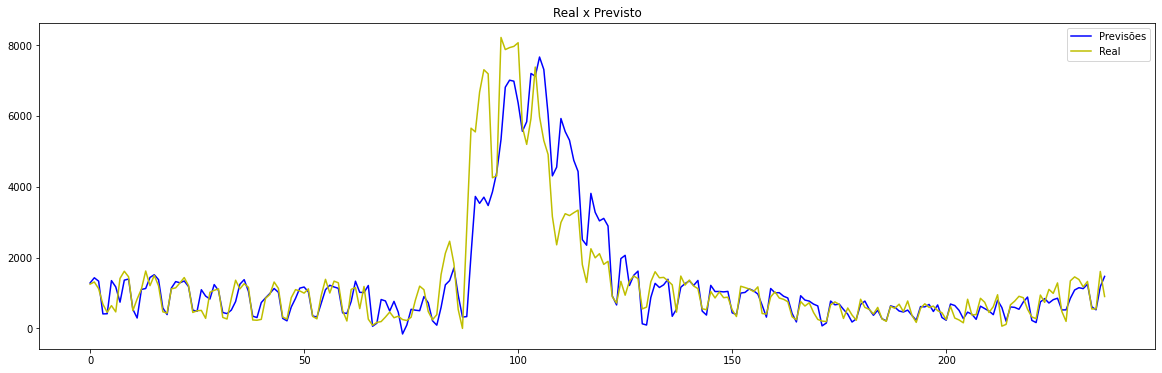

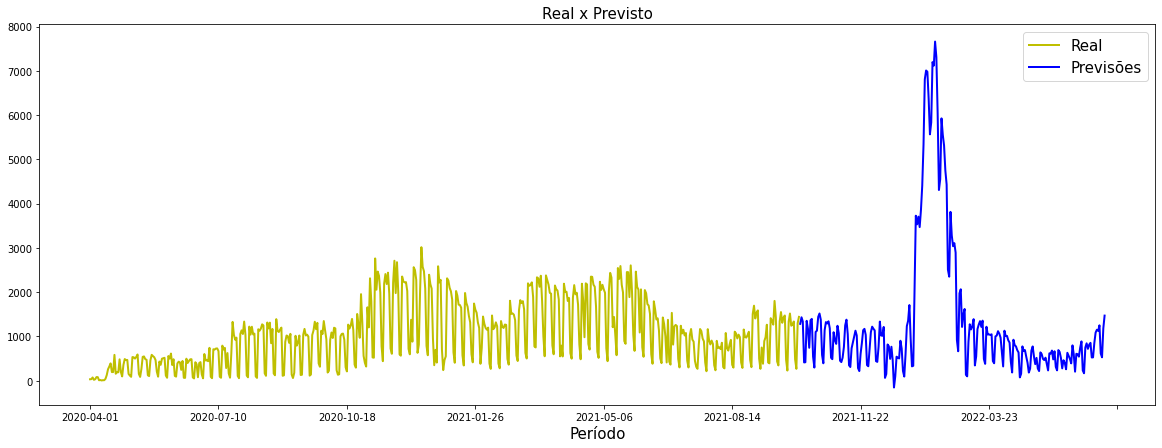

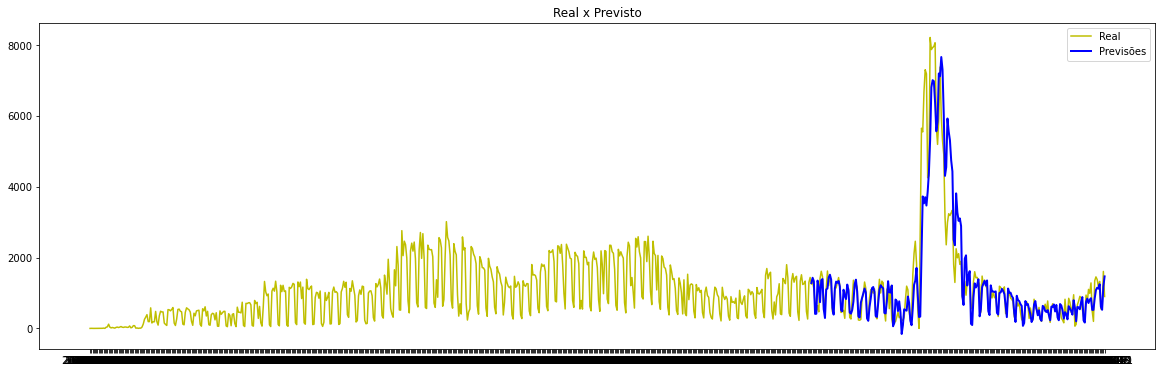

Janela Analisada:  45 dias

########################################
Melhor Score:  0.625345476616239
Melhores Parametros:  {'alpha': 1, 'gamma': 'scale', 'kernel': 'linear'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.625345476616239 {'alpha': 1, 'gamma': 'scale', 'kernel': 'linear'}
KRR model Results
r2 0.7847552524443893
mse 533624.3453287166
rmse 730.4959584615897
mae 393.6551594243029
mape 0.40096814659955216


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-package

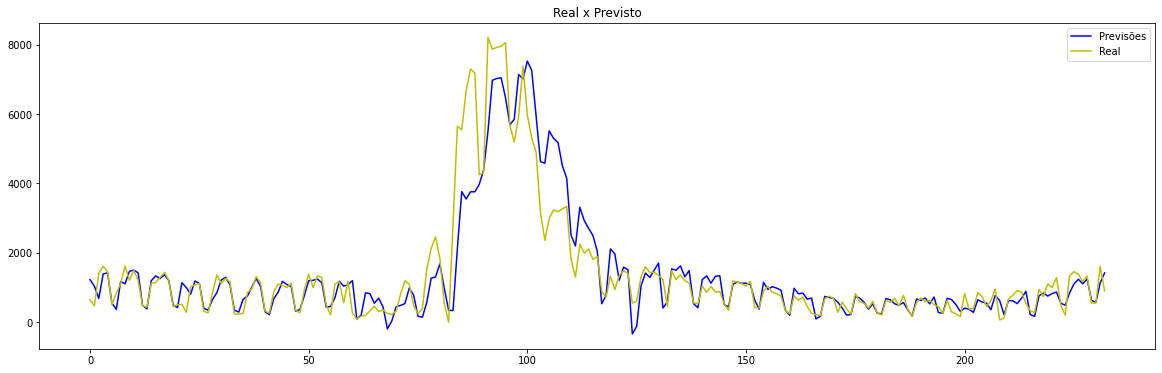

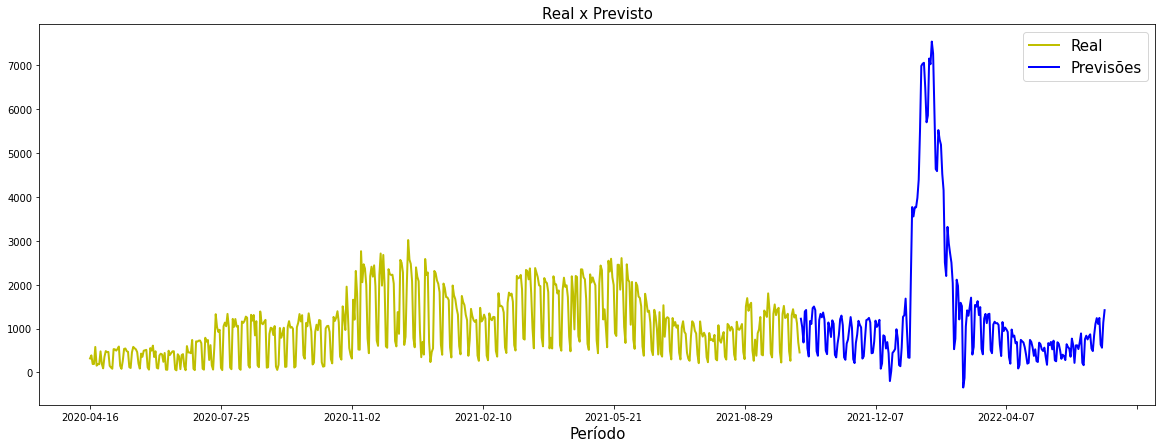

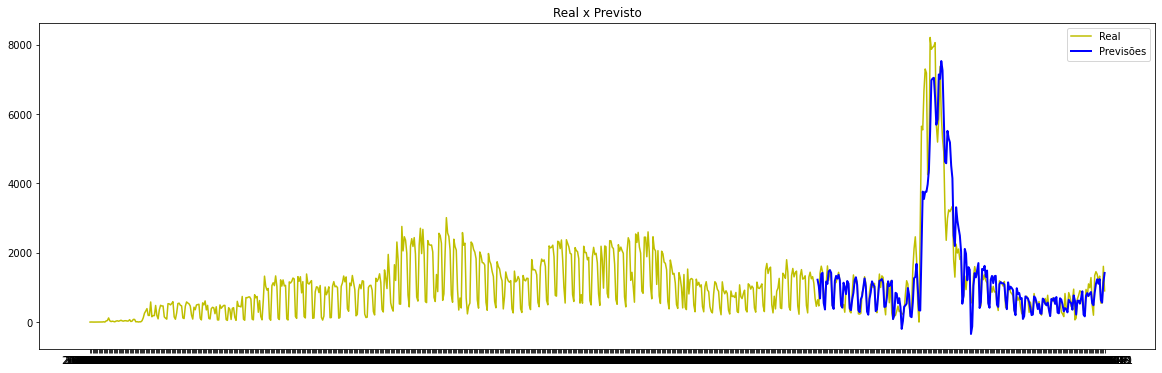

Janela Analisada:  60 dias

########################################
Melhor Score:  0.5772429970721086
Melhores Parametros:  {'alpha': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
########################################
Aplicando o Medelo Para os Melhores Parametros: 



0.5772429970721086 {'alpha': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
KRR model Results
r2 0.7766100526993528
mse 559652.6826305806
rmse 748.0993801832619
mae 415.63057792030565
mape 0.7296179949695432


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
200 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-package

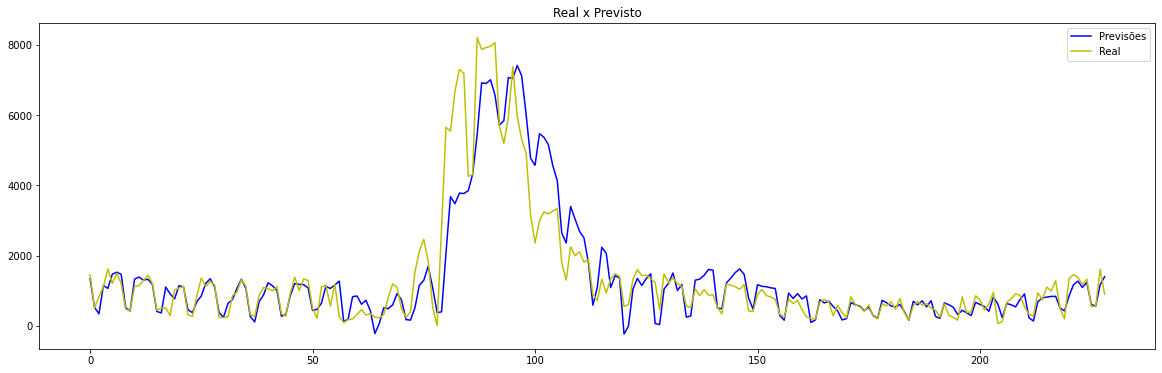

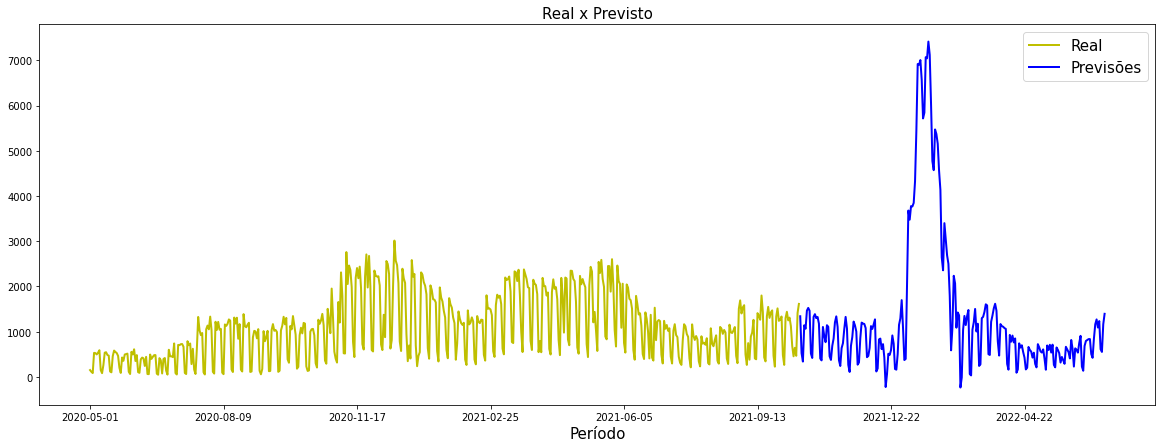

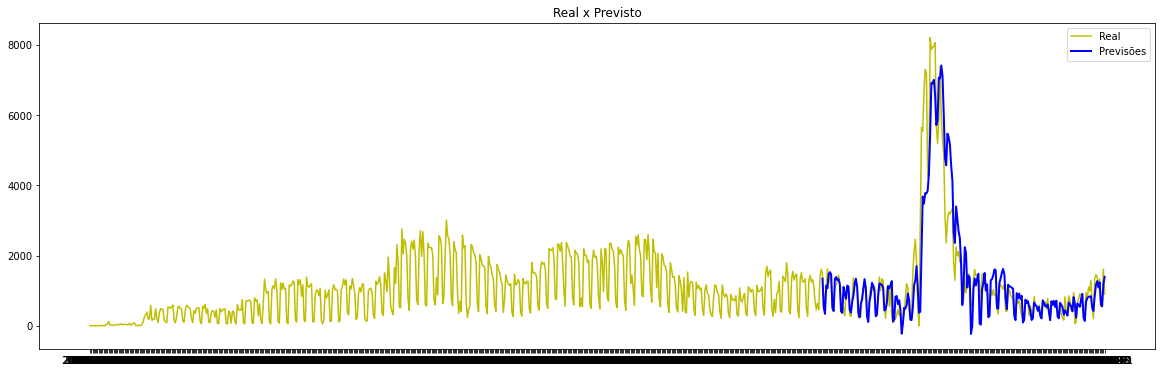

In [62]:
results = apl_for_lags (df_st)

### Resultados

In [63]:
df_results = pd.DataFrame(results, columns=('R2', 'MSE', 'RMSE','MAE','MAPE' ), index=('7 dias', '15 dias', '30 dias', '45 dias', '60 dias'))
df_results.sort_values(by='R2' , ascending = False)

,R2,MSE,RMSE,MAE,MAPE
45 dias,0.784755,533624.345329,730.495958,393.655159,0.400968
60 dias,0.776610,559652.682631,748.099380,415.630578,0.729618
30 dias,0.765556,581508.564967,762.567089,406.679262,0.401640
15 dias,0.759946,551420.887002,742.577193,403.914380,0.359841
7 dias,0.674853,780233.337257,883.308178,465.539779,0.392142
